In [1]:
#Collab bootstrapping for accessing files from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#Get the pickles
downloaded = drive.CreateFile({'id':"1aEoZt-nUQjvBum2342wuTBTdnxT98a2r"})
downloaded.GetContentFile('data_batch_1')

downloaded = drive.CreateFile({'id':"181kNZYyLqWNuYgX-d50Avf27GWoTbZZi"})
downloaded.GetContentFile('test_batch_trim')

In [3]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [4]:
from google.colab import drive
drive.mount('/content/drive')
drive_prefix = '/content/drive/My Drive/CE4042/Assignment2/PartA'

# Create folder to store models and results
if not os.path.exists(drive_prefix+'/models'):
    os.mkdir(drive_prefix+'/models')
if not os.path.exists(drive_prefix+'/results'):
    os.mkdir(drive_prefix+'/results')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Fixed, no need change
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    labels = np.array(labels, dtype=np.int32)
    return data, labels

In [6]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):
    ''' Note: This model is incomplete. You need to add suitable layers.
    '''

    model = tf.keras.Sequential()
    #First conv and maxpool
    model.add(layers.Conv2D(num_ch_c1, 9, padding='VALID', activation='relu', name="c1",input_shape=(32,32,3)))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=2,padding="VALID", name="s1"))
    #Second conv and maxpool
    model.add(layers.Conv2D(num_ch_c2, 5,padding='VALID',activation='relu',name="c2"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=2,padding='VALID',name="s2"))
    #Moving on to FCs
    model.add(layers.Flatten())
    #Dropout if needed
    if use_dropout is True:
      model.add(layers.Dropout(0.5))
    #FC1  
    model.add(layers.Dense(300,activation=None))
    #Dropout if needed
    if use_dropout is True:
      model.add(layers.Dropout(0.5))
    #Final FC (no more dropout after logit)
    model.add(layers.Dense(10, use_bias=True))  # Here no softmax because we have combined it with the loss
    return model


In [7]:
#Variables, constants and hyper parameters definition
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

num_ch_c1 = 70  # Question 2 optimal here
num_ch_c2 = 100  # Question 2 optimal here

epochs = 1000  # Fixed
batch_size = 128  # Fixed
learning_rate = 0.001
optimizer_ = ['SGD-momentum','RMSProp','Adam','SGD']  # Question 3
use_dropout = [False, False, False, True]  # Question 3(d) (see make_model)
get_feature_map = False #Decide if to generate feature map
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizers =[]
for optimizer in optimizer_:
  if optimizer == 'SGD':
      optimizers.append(keras.optimizers.SGD(learning_rate=learning_rate))
  elif optimizer == 'SGD-momentum':  # Question 3(a)
      optimizers.append(keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.1))
  elif optimizer == 'RMSProp':  # Question 3(b)
      optimizers.append(keras.optimizers.RMSprop(learning_rate=learning_rate))
  elif optimizer == 'Adam':  # Question 3(c)
      optimizers.append(keras.optimizers.Adam(learning_rate=learning_rate))
  else:
      raise NotImplementedError(f'You do not need to handle [{optimizer}] in this project.')

In [8]:
# Training and test
x_train, y_train = load_data('data_batch_1')
x_test, y_test = load_data('test_batch_trim')

print(x_train.shape)
print(x_test.shape)

#Reshape and transpose image
x_train = x_train.reshape(10000, 3, 32, 32).transpose(0,2,3,1)
x_test = x_test.reshape(2000, 3, 32, 32).transpose(0,2,3,1)

print(x_train.shape)
print(x_test.shape)

(10000, 3072)
(2000, 3072)
(10000, 32, 32, 3)
(2000, 32, 32, 3)


In [9]:
histories = []

for idx in range(4):
    print("Building model with %s optimizer and dropout %s"%(optimizer_[idx],use_dropout[idx]))
    #Build this model
    model = make_model(num_ch_c1,num_ch_c2,use_dropout[idx])
    model.summary()
    model.compile(optimizer=optimizers[idx], loss=loss, metrics='accuracy')
    #Training
    history= model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),verbose=0)
    
    histories.append(history)
    
    # Save model
    if use_dropout[idx]:
        model.save(f'{drive_prefix}/models/{num_ch_c1}_{num_ch_c2}_{optimizer_[idx]}_dropout')
    else:
        model.save(f'{drive_prefix}/models/{num_ch_c1}_{num_ch_c2}_{optimizer_[idx]}_no_dropout')

Building model with SGD-momentum optimizer and dropout False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c1 (Conv2D)                  (None, 24, 24, 70)        17080     
_________________________________________________________________
s1 (MaxPooling2D)            (None, 12, 12, 70)        0         
_________________________________________________________________
c2 (Conv2D)                  (None, 8, 8, 100)         175100    
_________________________________________________________________
s2 (MaxPooling2D)            (None, 4, 4, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               480300    
_____________________________________________________________

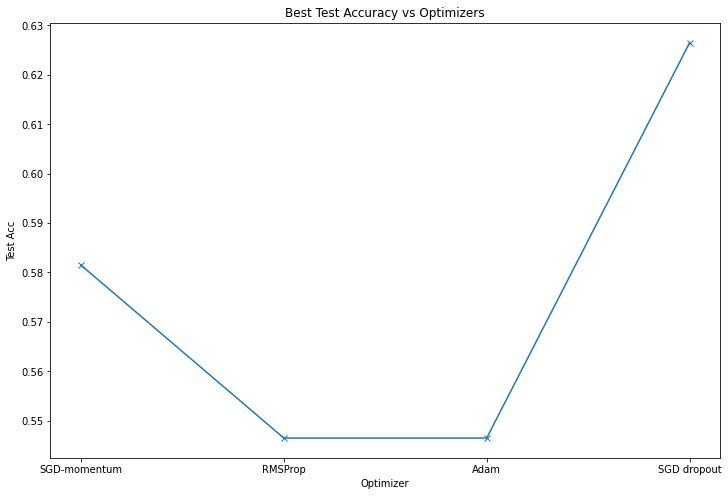

In [10]:
#Search for the best test accuracy amongst 4
best_results=[]
for obj in histories:
    best_test_acc = np.max(obj.history['val_accuracy'])
    best_results.append(best_test_acc)

labels = optimizer_
labels[-1]='SGD dropout'
#Plot out in scatter plot
plt.figure(figsize=(12,8))
plt.plot(labels,best_results, marker = 'x')
plt.title('Best Test Accuracy vs Optimizers')
plt.ylabel('Test Acc')
plt.xlabel('Optimizer')
plt.savefig(f'{drive_prefix}/results/best_accuracy_3A.png')

In [11]:
print(best_results)

[0.5814999938011169, 0.546500027179718, 0.546500027179718, 0.6265000104904175]


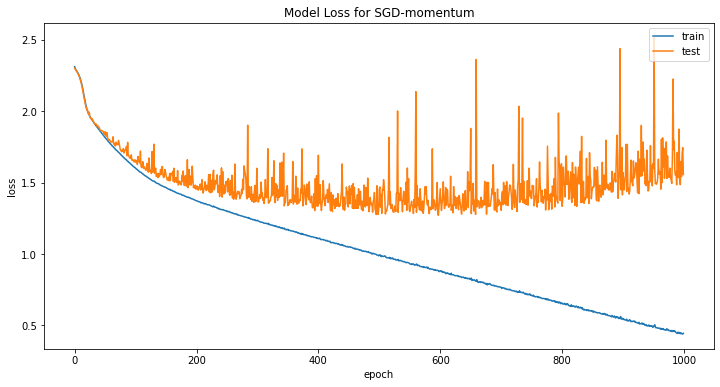

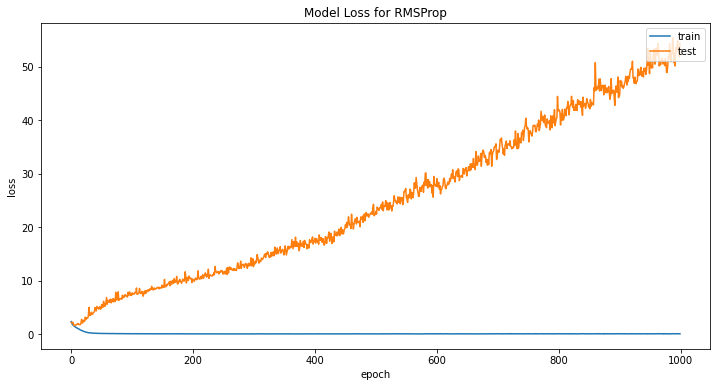

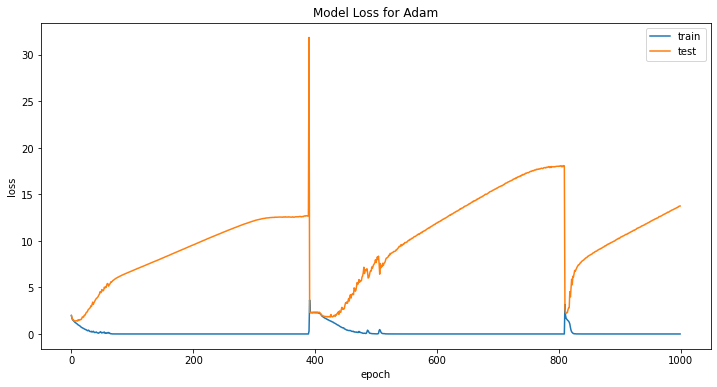

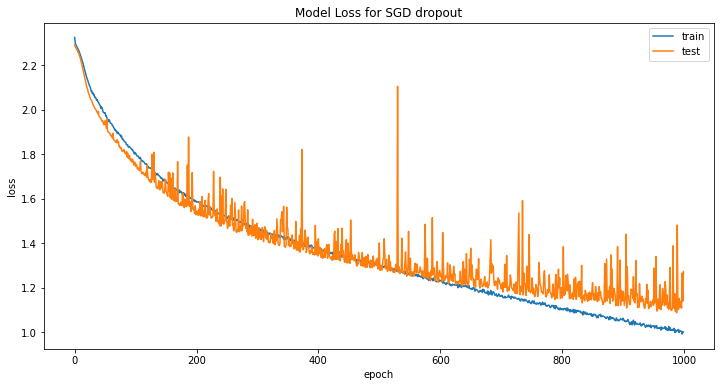

In [12]:
# Save the plot for losses
for idx in range(4):
  plt.figure(figsize=(12,6))
  plt.plot(histories[idx].history['loss'])
  plt.plot(histories[idx].history['val_loss'])
  plt.title("Model Loss for %s"%labels[idx])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc= 'upper right' )
  if use_dropout[idx]:
      plt.savefig(
          f'{drive_prefix}/results/{num_ch_c1}_{num_ch_c2}_{optimizer_[idx]}_dropout_loss.png')
  else:
      plt.savefig(
          f'{drive_prefix}/results/{num_ch_c1}_{num_ch_c2}_{optimizer_[idx]}_no_dropout_loss.png')
  plt.show()

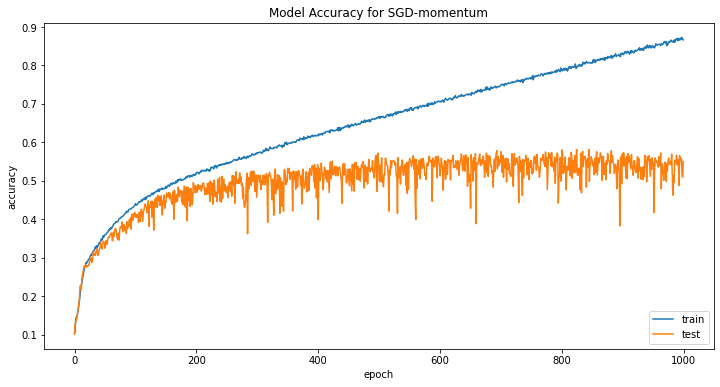

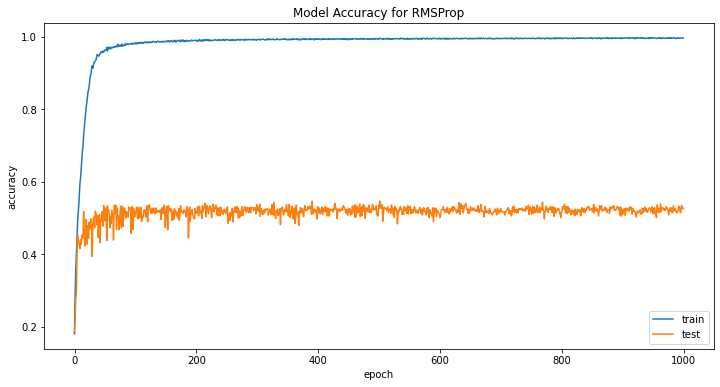

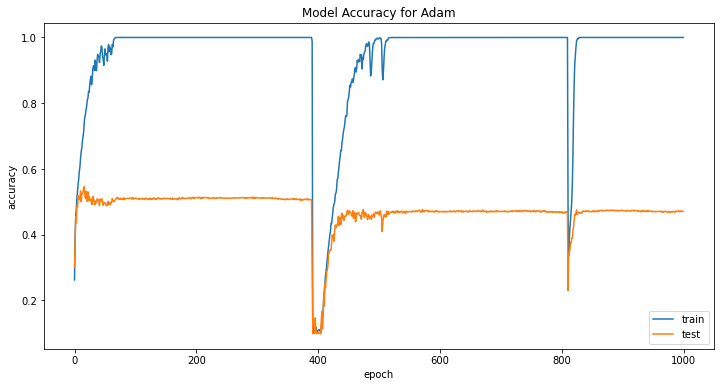

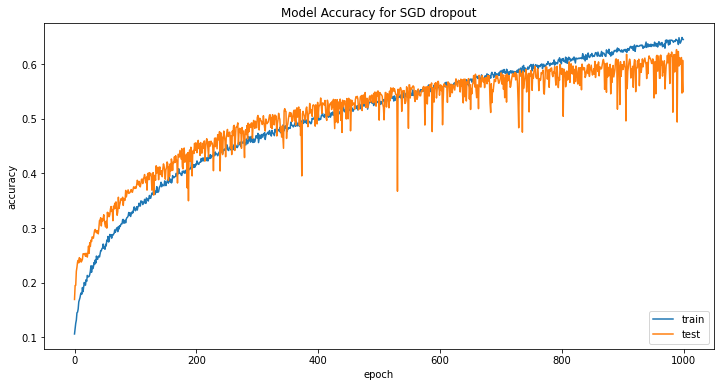

In [13]:
# Save the plot for accuracies
for idx in range(4):
  plt.figure(figsize=(12,6))
  plt.plot(histories[idx].history['accuracy'])
  plt.plot(histories[idx].history['val_accuracy'])
  plt.title("Model Accuracy for %s"%labels[idx])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc= 'lower right' )
  if use_dropout[idx]:
      plt.savefig(
          f'{drive_prefix}/results/{num_ch_c1}_{num_ch_c2}_{optimizer_[idx]}_dropout_accuracy.png'
      )
  else:
      plt.savefig(
          f'{drive_prefix}/results/{num_ch_c1}_{num_ch_c2}_{optimizer_[idx]}_no_dropout_accuracy.png'
      )
  plt.show()

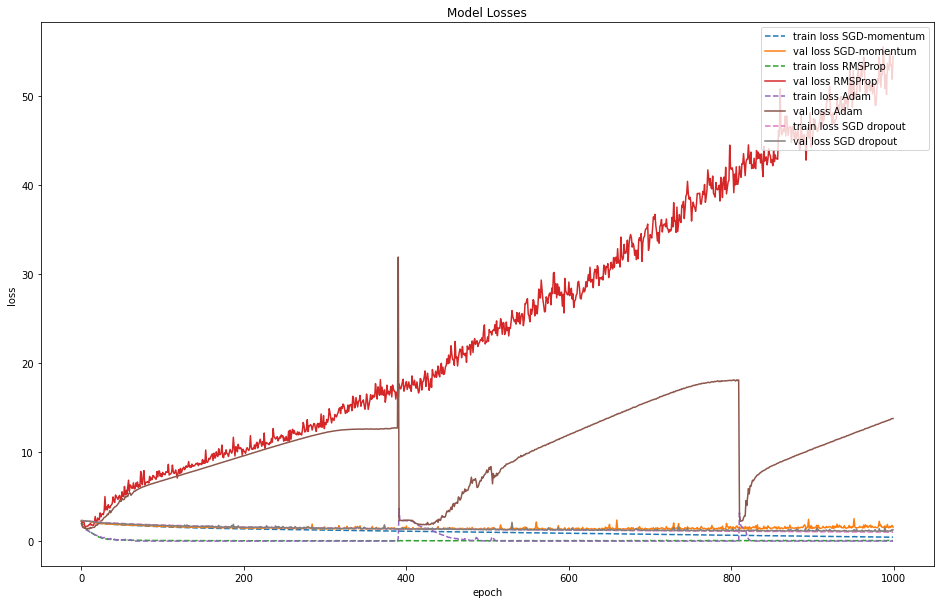

In [14]:
#Plot all the loss together
plt.figure(figsize=(16,10))
for idx in range(4):
  plt.plot(histories[idx].history['loss'],label = "train loss %s"%labels[idx], linestyle='dashed')
  plt.plot(histories[idx].history['val_loss'],label = "val loss %s"%labels[idx])
plt.title("Model Losses")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc= 'upper right' )
plt.savefig(f'{drive_prefix}/results/combined_losses_3A.png')
plt.show()


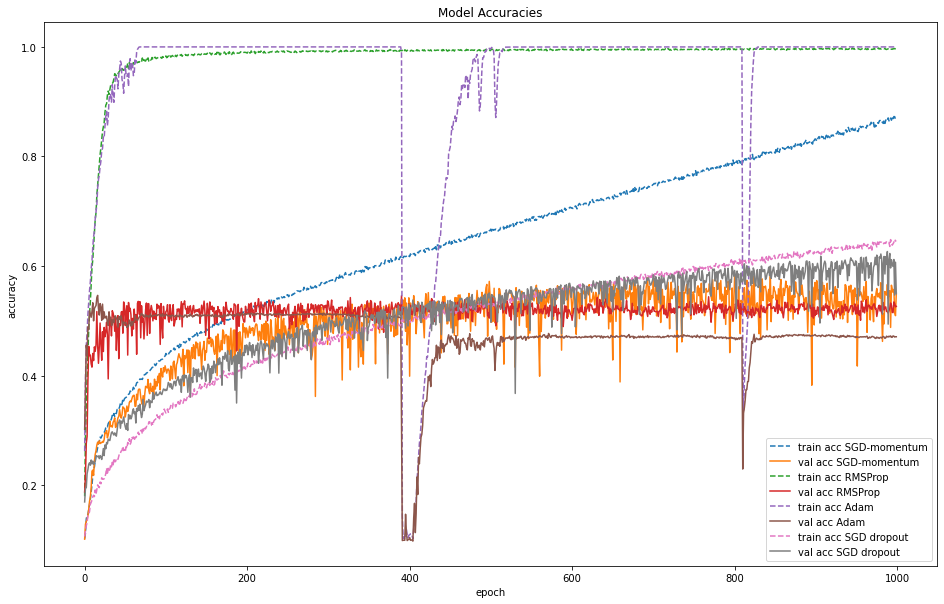

In [15]:
#Plot all the acc together
plt.figure(figsize=(16,10))
for idx in range(4):
  plt.plot(histories[idx].history['accuracy'],label = "train acc %s"%labels[idx],linestyle='dashed')
  plt.plot(histories[idx].history['val_accuracy'],label = "val acc %s"%labels[idx])
plt.title("Model Accuracies")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc= 'lower right' )
plt.savefig(f'{drive_prefix}/results/combined_l_3A.png')
plt.show()